# NGC analysis for baseball data

- In this notebook, we train a cMLP model on motion capture data of pitcher and batter
- This notebook is mostly based on the sample code of the original article [Alex Tank, Ian Covert, Nicholas Foti, Ali Shojaie, Emily Fox. "Neural Granger Causality." *Transactions on Pattern Analysis and Machine Intelligence*, 2021].

In [8]:
# Please set the file path for your environment before running the code
# Import library
import os
import torch
import csv
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from models.cmlp import cMLP, train_model_ista

In [41]:
#Load motion capture data
#The data has been pre-processed. You can refer the detailes of it in the orignal article.
data=torch.zeros([10,625,27])

#Use pair1's data as a typical example (but there are some individual differences, please also refer the supporting information )
dir_path = "./input_datasets/pair1/"
file_list = glob.glob(os.path.join(dir_path, "*.csv"))
count=0;
for file_path in file_list:
    file = pd.read_csv(file_path, header=None)
    for i in range(file.shape[0]):
      for j in range(file.shape[1]):
        data[count][i][j]=np.float_(file[j][i])
    count=count+1;

#Set dawn sampling rate (5: 250 to 50 Hz)
dawn_size=5;

if data.size()[1]%dawn_size>0:
  add=1
else:
  add=0

data_d=torch.zeros([data.size()[0],data.size()[1]//dawn_size+add,data.size()[2]])

for i in range(data_d.size()[0]):
  count=0
  for j in range(len(data[0])):
    if j%dawn_size==0:
       for k in range(data_d.size()[2]):
         data_d[i][count][k]=data[i][j][k]
       count=count+1

# Train cMLP model by datsets. Please refer the supporting information for tuning the hyper parameters.

In [42]:
# For GPU acceleration
device = torch.device('cuda')

# Send the data to GPU
X_motion = data_d
X_motion = X_motion.to(device)

# Set up model
# You can change the lag setting (currently, 1 sec: 50 points)
cmlp = cMLP(X_motion.shape[-1], lag=50, hidden=[32]).cuda(device=device)

# Train with ISTA
train_loss_list = train_model_ista(cmlp, X_motion, lr=5e-2, max_iter=2000, lam=0.003, lam_ridge=1e-2, penalty='GSGL',
                                   lookback=10, check_every=100, verbose=1)

#GC: (p x p) or (p x p x lag) matrix. In first case, entry (i, j)
#            indicates whether variable j is Granger causal of variable i. In
#            second case, entry (i, j, k) indicates whether it's Granger causal
#            at lag k.

----------Iter = 100----------
Loss = 0.340079
Variable usage = 100.00%
----------Iter = 200----------
Loss = 0.261135
Variable usage = 100.00%
----------Iter = 300----------
Loss = 0.183370
Variable usage = 100.00%
----------Iter = 400----------
Loss = 0.107436
Variable usage = 100.00%
----------Iter = 500----------
Loss = 0.039288
Variable usage = 100.00%
----------Iter = 600----------
Loss = 0.017946
Variable usage = 72.43%
----------Iter = 700----------
Loss = 0.016563
Variable usage = 62.69%
----------Iter = 800----------
Loss = 0.015890
Variable usage = 56.24%
----------Iter = 900----------
Loss = 0.015625
Variable usage = 53.09%
----------Iter = 1000----------
Loss = 0.015159
Variable usage = 49.38%
----------Iter = 1100----------
Loss = 0.015283
Variable usage = 47.19%
----------Iter = 1200----------
Loss = 0.015026
Variable usage = 44.44%
----------Iter = 1300----------
Loss = 0.014697
Variable usage = 42.39%
----------Iter = 1400----------
Loss = 0.014515
Variable usage = 39.

<Axes: >

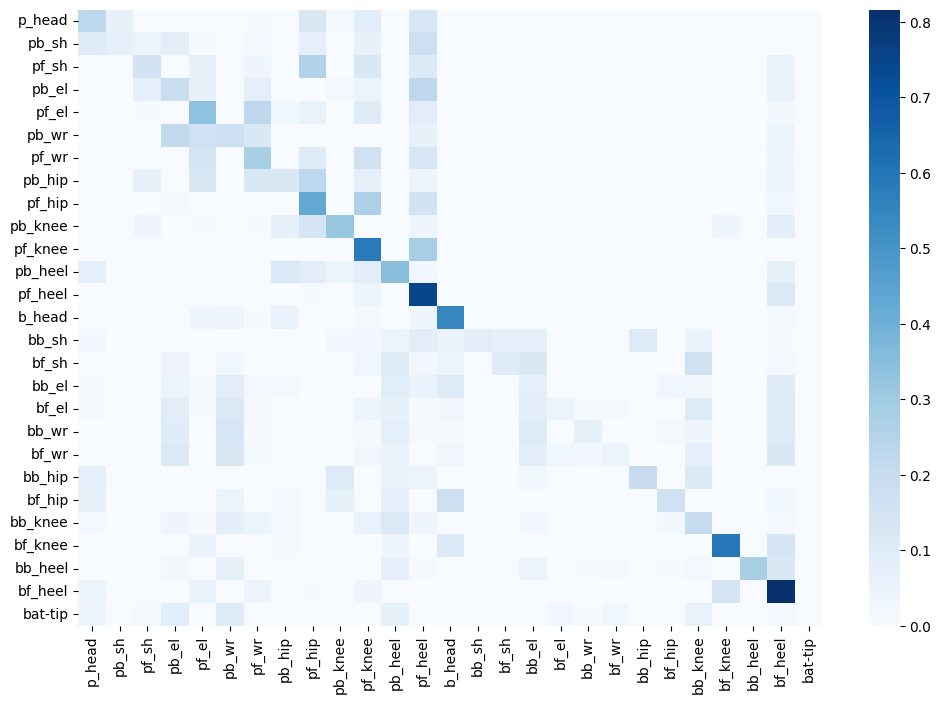

In [48]:
#Check the training results
#Extract NGC matrix while igoring the lag
#If you want to include the lag information, set "threshold=Trule"

GC_est = cmlp.GC(threshold=False).cpu().data.numpy()

#Describe heatmap
ptics=["p_head","pb_sh","pf_sh","pb_el","pf_el","pb_wr","pf_wr","pb_hip","pf_hip","pb_knee","pf_knee","pb_heel","pf_heel"]
btics=["b_head","bb_sh","bf_sh","bb_el","bf_el","bb_wr","bf_wr","bb_hip","bf_hip","bb_knee","bf_knee","bb_heel","bf_heel","bat-tip"]
ptics.extend(btics)

plt.figure(figsize=(12, 8))
sns.heatmap(GC_est,cmap='Blues',annot=False,xticklabels=ptics,yticklabels=ptics)


Text(0, 0.5, 'NGC')

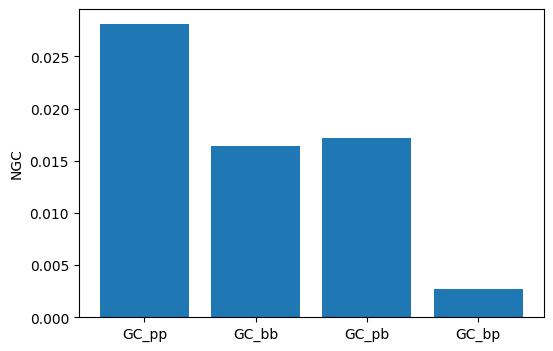

In [56]:
#Set 0 for diag value to focus on the inter-joint causality
GC_est[range(27),range(27)]=0

# Caululate four causal indexes (pair1 has relatively large GC_pb)
GC_pp=np.sum(GC_est[0:12,0:12])/(13*(13-1))
GC_bb=np.sum(GC_est[13:26,13:26])/(14*(14-1))
GC_pb=np.sum(GC_est[13:26,0:12])/(14*13)
GC_bp=np.sum(GC_est[0:12,13:26])/(13*14)

x_value = np.array([1, 2, 3, 4])
y_value= np.array([GC_pp,GC_bb,GC_pb,GC_bp])

x_label = ["GC_pp", "GC_bb", "GC_pb", "GC_bp"]

plt.figure(figsize=(6, 4))
plt.bar(x_value, y_value, tick_label=x_label, align="center")
plt.ylabel("NGC")